In [1]:
%matplotlib inline

import cv2
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import rotate
import PIL
import matplotlib.pyplot as plt
import math
from scipy.fft import fft, fftfreq, fftshift
from libmtf import read_image, Point, ROI, get_roi, get_hamming, get_deriv1, get_centroid, get_polyfit, get_fir2fix, project2

In [3]:
lpdg = 6.25
lpdg = 12.5

In [4]:
def plot_images(image_left, image_right):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    axes[0].imshow(image_left, "gray")
    axes[0].set_title("hori line")
    
    axes[1].imshow(image_right, "gray")
    axes[1].set_title("vert line")
    
def step0_load_image(filename):
    image = read_image(filename)
    return image

def step1_get_roimage(image, topleft, bottomright, rotation):
    roi_image, roi = get_roi(image, topleft, bottomright)
    roi_image = rotate(roi_image, rotation)
    return roi_image, roi

def get_derivative(roi_image):
    deriv = roi_image
    return roi_image

def plot_curves(curve_l, title_l, curve_r, title_r):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    axes[0].plot(curve_l)
    axes[0].set_title(title_l)
    
    axes[1].plot(curve_r)
    axes[1].set_title(title_r)
    
def plot_derivatives(deriv_l, deriv_r):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    for i in range(deriv_l.shape[0]):
        axes[0].plot(deriv_l[i, :])
    axes[0].set_title("hori line: LSF for all rows")
    
    for i in range(deriv_l.shape[0]):
        axes[1].plot(deriv_r[i, :])
    axes[1].set_title("vert line: LSF for all rows")

def get_fit(curve):
    x = np.arange(len(curve))
    y = curve
    fit = get_polyfit(x, y, 1)
    return fit
    
def step4_get_centroid_and_fit(deriv, hamming_win):
    centroid = get_centroid(deriv * hamming_win) - 0.5
    fit = get_fit(centroid)
    return centroid, fit

def plot_centroid(image_l, centroid_l, fit_l, image_r, centroid_r, fit_r):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    axes[0].imshow(image_l, "gray")
    axes[0].set_title("hori line")
    axes[0].plot(centroid_l, np.arange(len(centroid_l)), 'r')
    x = np.arange(len(centroid_l))
    y = centroid_l
    axes[0].plot(np.polyval(fit_l, x), x, "y")
    
    axes[1].imshow(image_r, "gray")
    axes[1].set_title("vert line")
    axes[1].plot(centroid_r, np.arange(len(centroid_r)), 'r')
    x = np.arange(len(centroid_r))
    y = centroid_r
    axes[1].plot(np.polyval(fit_r, x), x, "y")
    

def plot_lsf(lsf_curve, centroid, fit, roi_image_limited):
    plt.subplot(1, 2, 1)
    plt.title("LSF after Hamming window")
    plt.imshow(lsf_curve)
    plt.plot(centroid, np.arange(len(centroid)), 'r')

    x = np.arange(len(centroid))
    y = centroid
    plt.plot(np.polyval(fit, x), x, "y")

    plt.subplot(1, 2, 2)
    plt.title("LSF limted")
    plt.imshow(roi_image_limited)

def step5_fit_central(fit, centroid, deriv_v, win1_v):
    centroid_place = np.polyval(fit, np.arange(len(centroid)))
    hamming_width = deriv_v.shape[1]

    win2 = [get_hamming(hamming_width, centroid_place[i]) for i in range(len(centroid_place))]
    win2 = np.array(win2)
    deriv_hamming_windowed = deriv_v*win2

    centroid, fit = step4_get_centroid_and_fit(deriv_hamming_windowed, win1_v)

    slout_ = -fit[0]
    slout = 180*math.atan(slout_)/math.pi

    # Evaluate equation at the middle line as edge location
    midloc = np.polyval(fit, deriv_v.shape[0]/2)

    # Limit number of lines to integer (npix*line slope as per ISO 12233
    nlin = deriv_v.shape[0]
    a = math.floor(nlin*abs(slout))
    b = abs(slout)
    nlin1 = round(a/b)

    roi_image_limited = deriv_hamming_windowed[:nlin1, :]

    # plot_lsf(deriv_hamming_windowed, centroid, fit, roi_image_limited)

    vslope = -fit[0]
    slope_deg = slout
    delimage = 1

    # correct sampling interval for sampling normal to edge
    delfac = math.cos(math.atan(vslope))

    # input pixel sampling normal to edge
    del1n = delfac
    nbin = 4
    # super-sampling interval normal to edge
    del2 = del1n/nbin

    nn = math.ceil(deriv_hamming_windowed.shape[1]*nbin)
    nn2 = math.floor(nn/2) + 1

    # dcorr corrects SFR for response of FIR filter
    dcorr = get_fir2fix(nn2, 3)

    freqlim = 1
    if nbin == 1:
        freqlim = 2
        
    nn2out = round(nn2*freqlim/2)

    # half-sampling frequency
    nfreq = nn/(2*delimage*nn)    

    return roi_image_limited, nbin, nn2, del2

def step6_super_sample(roi_image_limited, fit, nbin):
    esf = project2(roi_image_limited, fit, nbin)
    l = len(esf)
    esf[l-1] = esf[l-2]
    return esf

def step7_get_lsf(esf):
    lsf1 = esf
    return lsf1

def step8_apply_win_to_lsf(lsf1_v):
    nn = len(lsf1_v)
    mm = np.argmax(lsf1_v)

    win3_v = get_hamming(nn, mm)
    win3_v = np.array(win3_v)
    lsf1_v = np.array(lsf1_v)
    lsf_v = lsf1_v * win3_v

    return lsf_v, win3_v

def step9_get_mtf(lsf, nn2, del2):
    temp = abs(fft(lsf))
    mtf = temp[0:nn2] / temp[0]
    # Compute frequency values

    # print("del2", del2, "nn", nn)
    nn = len(lsf)
    freq = [i / (del2*nn) for i in range(nn)]
    freq = np.array(freq)
    mtf = np.array(mtf)

    nn_2_out = 70
    nn2out=nn_2_out # for smartmtf
    efl = 60
    px = 3.45
    px=2.74

    lppd = px/efl/1000 * 180/3.14159

    freq_data = freq[0:nn2out]/lppd
    mtf_data = mtf[0:nn2out]

    return freq_data, mtf_data

def step10_get_mtf_interp(mtf_array, freq_array, frequency):
    for idx, freq in enumerate(freq_array):
        # print(idx, freq)
        if frequency < freq:
            break

    mtf = (frequency-freq_array[idx-1])/(freq_array[idx]-freq_array[idx-1])*(mtf_array[idx]-mtf_array[idx-1]) + mtf_array[idx-1]
    return frequency, mtf
    
def plot_mtf(freq_data, mtf_data, label, linestyle):
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.plot(freq_data, mtf_data, label=label, linestyle=linestyle)
    plt.legend()

In [5]:
def thru_focus(index, freq, files, w, h, debug=False):
    # step 0: load image
    file_item = files[index]
    image = step0_load_image(file_item["filename"])
    title = file_item["title"]
    
    # step 1: get ROI
    roi_image_h, roi = step1_get_roimage(image, file_item["roi_h_pos"], (file_item["roi_h_pos"][0] + w, file_item["roi_h_pos"][1] + h), 90) #90
    roi_image_v, roi = step1_get_roimage(image, file_item["roi_v_pos"], (file_item["roi_v_pos"][0] + h, file_item["roi_v_pos"][1] + w), 0)
    if debug:
        plot_images(roi_image_h, roi_image_v)
    
    # step 2: hamming window
    win1_h = get_hamming(roi_image_h.shape[1])
    win1_v = get_hamming(roi_image_v.shape[1])
    
    # step 3: get derivative
    deriv_h = get_derivative(roi_image_h)
    deriv_v = get_derivative(roi_image_v)
    if debug:
        plot_derivatives(deriv_h, deriv_v)
    
    # step 4: apply window and compute centroid
    centroid_h, fit_h = step4_get_centroid_and_fit(deriv_h, win1_h)
    centroid_v, fit_v = step4_get_centroid_and_fit(deriv_v, win1_v)
    if debug:
        plot_centroid(deriv_h, centroid_h, fit_h, deriv_v, centroid_v, fit_v)
    
    # step 5: compute polynomial fit to central locations
    
    roi_image_limited_h, nbin_h, nn2_h, del2_h = step5_fit_central(fit_h, centroid_h, deriv_h, win1_h)
    roi_image_limited_v, nbin_v, nn2_v, del2_v = step5_fit_central(fit_v, centroid_v, deriv_v, win1_v)
    if debug:
        print("roi_image_limited_h:", roi_image_limited_h.shape)
        print("roi_image_limited_v:", roi_image_limited_v.shape)
        print("nbin_h:", nbin_h)
        print("nbin_v:", nbin_v)
        print("nn2_h:", nn2_h)
        print("nn2_v:", nn2_v)
        print("del2_h:", del2_h)
        print("del2_v:", del2_v)
        plot_images(roi_image_limited_h, roi_image_limited_v)
        
    # step 6: super-sample
    esf_h = step6_super_sample(roi_image_limited_h, fit_h, nbin_h)
    esf_v = step6_super_sample(roi_image_limited_v, fit_v, nbin_v)
    if debug:
        plot_curves(esf_h, "esf_h", esf_v, "esf_v")
    
     # step 7: compute 1D derivative (LSF)
    
    lsf1_h = step7_get_lsf(esf_h)
    lsf1_v = step7_get_lsf(esf_v)
    if debug:
        plot_curves(lsf1_h, "lsf_h", lsf1_v, "lsf_v")
    
    # step 8: apply window to LSF
    
    lsf_h, win3_h = step8_apply_win_to_lsf(lsf1_h)
    lsf_v, win3_v = step8_apply_win_to_lsf(lsf1_v)
    # plt.subplot(1, 2, 1)
    # plt.title("without hamming")
    # plt.plot(lsf_h)
    
    # plt.subplot(1, 2, 2)
    # plt.title("hamming")
    # plt.plot(lsf1_h * win3_h)
    # plt.plot(win3_h*200) 
    
    # step 9: MTF
    freq_data_h, mtf_data_h = step9_get_mtf(lsf_h, nn2_h, del2_h)
    freq_data_v, mtf_data_v = step9_get_mtf(lsf_v, nn2_v, del2_v)
    # plot_mtf(freq_data_h, mtf_data_h, "h", "-")
    # plot_mtf(freq_data_v, mtf_data_v, "v", "--")
    
    freq, mtf_h = step10_get_mtf_interp(mtf_data_h, freq_data_h, freq)
    freq, mtf_v = step10_get_mtf_interp(mtf_data_v, freq_data_v, freq)

    result = {
        "title": title,
        "freq": freq,
        "mtf_h": float(mtf_h),
        "mtf_v": float(mtf_v),
        "roi_image_h": roi_image_h,
        "roi_image_v": roi_image_v,
        "lsf_h": lsf_h,
        "lsf_v": lsf_v,
        "freq_data": freq_data_h,
        "mtf_data_h": mtf_data_h,
        "mtf_data_v": mtf_data_v
    }
    return result

def do_thru_focus(scan_files):
    t_focus_d = []
    t_focus_h = []
    t_focus_v = []
    
    freq_numbers = 40
    freqency = lpdg
    
    for idx in range(len(scan_files)):
        res = thru_focus(idx, freqency, scan_files, 100, 100, False)
        # print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
        t_focus_d.append(float(res["title"][0:-2]))
        t_focus_h.append(res["mtf_h"])
        t_focus_v.append(res["mtf_v"])
    return t_focus_d, t_focus_h, t_focus_v

In [6]:
# display ROIs
def display_roi(scan_files, idx, w, h):
    freq_numbers = 20
    freqency = lpdg
    # idx = 10
    
    res = thru_focus(idx, freqency, scan_files, w, h, False)
    # print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
    # t_focus_d.append(float(res["title"][0:-2]))
    # t_focus_h.append(res["mtf_h"])
    # t_focus_v.append(res["mtf_v"])
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(res["roi_image_h"], "gray")
    axes[0].set_title("hori line")
    
    axes[1].imshow(res["roi_image_v"], "gray")
    axes[1].set_title("vert line")
    
    axes[2].plot(res["freq_data"][0:freq_numbers], res["mtf_data_h"][0:freq_numbers], label='MTF in H line', linestyle='-')
    axes[2].plot(res["freq_data"][0:freq_numbers], res["mtf_data_v"][0:freq_numbers], label='MTF in V line', linestyle='-')
    axes[2].set_title(f"motor position: {res['title']}")
    axes[2].set_xlabel("lp/deg")
    axes[2].grid(color='gray', linestyle='--', linewidth=1)
    axes[2].legend()

def plot_thrufocus(t_focus_d, t_focus_h, t_focus_v, title):
    plt.grid(color="gray", linestyle="--", linewidth=1)
    plt.plot(t_focus_d, np.array(t_focus_h), label="h line", linestyle="-")
    plt.plot(t_focus_d, np.array(t_focus_v), label="v line", linestyle="--")
    plt.xlabel("motor position")
    plt.ylabel("MTF")
    plt.title(title)
    plt.legend()

def adjust_thrufocus(t_focus_d, t_focus_h, t_focus_v, kh, kv, shift=0):
    ah = np.array(t_focus_h)*kh
    av = np.array(t_focus_v)*kv
    ad = np.array(t_focus_d)
    if shift > 0:
        ad = ad[shift:]
        ah = ah[shift:]
        av = av[:-shift]
    elif shift < 0:
        ad = ad[:shift]
        ah = ah[:shift]
        av = av[-shift:]

    return ad, ah, av

## References:
- Mirror
  + center: 1232,862
  + exposure time: 350us
- Beam splitter
  + center: 1221,878
  + exposure time: 1000us

## Test Samples:
- A
  + center: 1194,907
  + exposure time: 1200us
- X
  + center: 1251,970
  + exposure time: 500us
- Pxa (with QR code)
  + center: 1248,1107
  + exposure time: 1200us
- Pxb
  + center: 1129, 1052
  + exposure time: 1200us
- P2a (with QR code)
  + exposure time: 850us
- P2b
  + center: 1248,955
  + exposure time: 850us

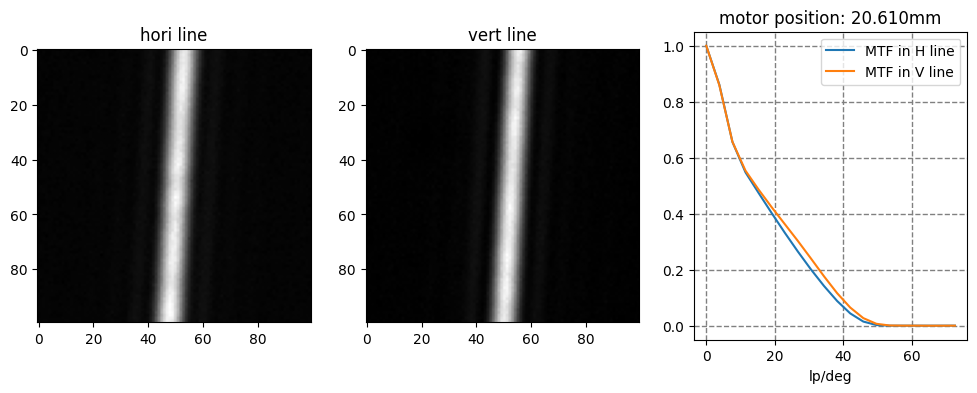

In [7]:
# A vid 1.54m #3
a_2mm_140mm_2000us = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0814/a_2mm_140mm_2000us/{idx/1000:.3f}.png",
    "roi_h_pos": (1321, 842),
    "roi_v_pos": (1157, 965),
} for idx in range(19510, 21900, 10)]

display_roi(a_2mm_140mm_2000us, 110, 100, 100)

In [8]:
t_focus_d_a2mm, t_focus_h_a2mm, t_focus_v_a2mm = do_thru_focus(a_2mm_140mm_2000us)

In [14]:
ad, ah, av = adjust_thrufocus(t_focus_d_a2mm, t_focus_h_a2mm, t_focus_v_a2mm, kh=1.01, kv = 1.00, shift=-9)
x = (np.arange(ah.shape[0]))
zh = np.polyfit(x, ah, 2)
ph = np.poly1d(zh)
afh = ph(x)
zv = np.polyfit(x, av, 2)
pv = np.poly1d(zv)
afv = pv(x)
print(afh.argmax(), afh.max())
print(afv.argmax(), afv.max())

121 0.5335655553722047
122 0.5395142680826828


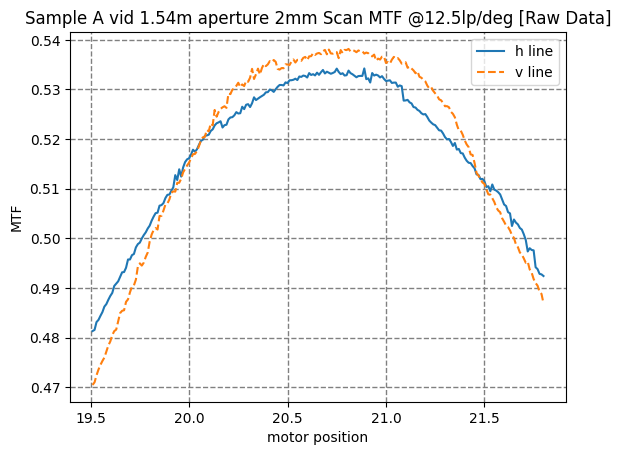

In [15]:
plot_thrufocus(ad, ah, av, title=f"Sample A vid 1.54m aperture 2mm Scan MTF @{lpdg}lp/deg [Raw Data]")

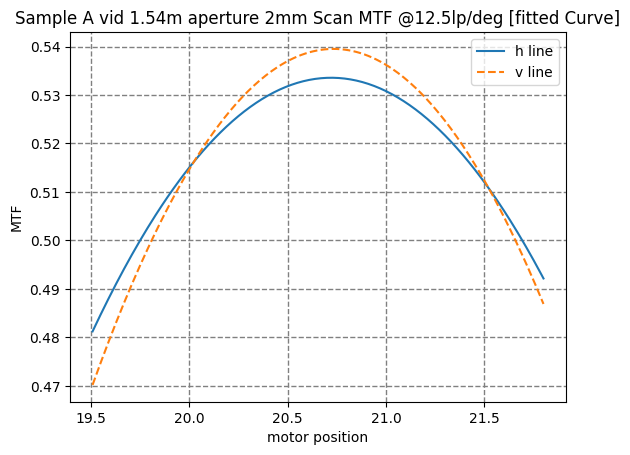

In [16]:
plot_thrufocus(ad, afh, afv, title=f"Sample A vid 1.54m aperture 2mm Scan MTF @{lpdg}lp/deg [fitted Curve]")

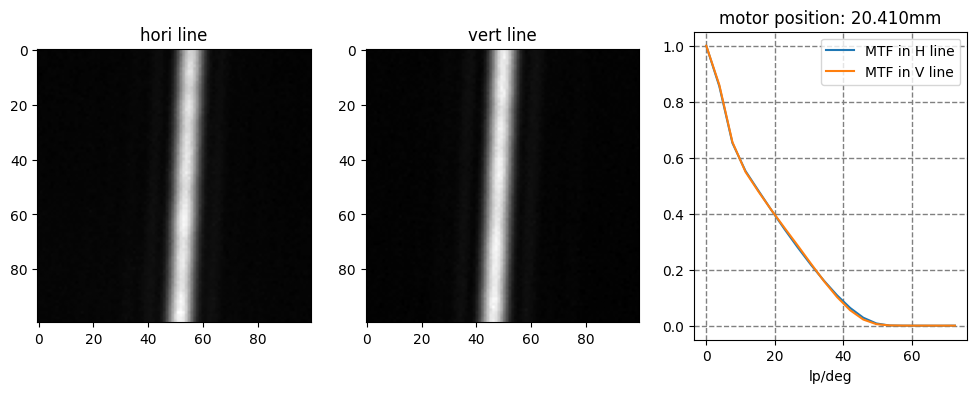

In [17]:
# X vid 1.54m #3
x_2mm_140ma_2000us = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0814/x_2mm_140ma_2000us/{idx/1000:.3f}.png",
    "roi_h_pos": (1278, 1164),
    "roi_v_pos": (1155, 1278),
} for idx in range(19510, 21900, 10)]

display_roi(x_2mm_140ma_2000us, 90, 100, 100)

In [18]:
t_focus_d_x2mm, t_focus_h_x2mm, t_focus_v_x2mm = do_thru_focus(x_2mm_140ma_2000us)

In [57]:
ad, ah, av = adjust_thrufocus(t_focus_d_x2mm, t_focus_h_x2mm, t_focus_v_x2mm, kh=1.00, kv = 1.00, shift=-9)
x = (np.arange(ah.shape[0]))
zh = np.polyfit(x, ah, 2)
ph = np.poly1d(zh)
afh = ph(x)
zv = np.polyfit(x, av, 2)
pv = np.poly1d(zv)
afv = pv(x)
print(afh.argmax(), afh.max())
print(afv.argmax(), afv.max())

126 0.53930873497545
120 0.5396153860014307


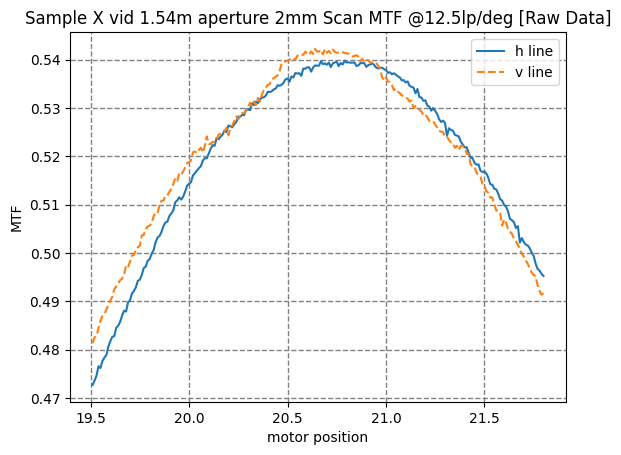

In [58]:
plot_thrufocus(ad, ah, av, title=f"Sample X vid 1.54m aperture 2mm Scan MTF @{lpdg}lp/deg [Raw Data]")

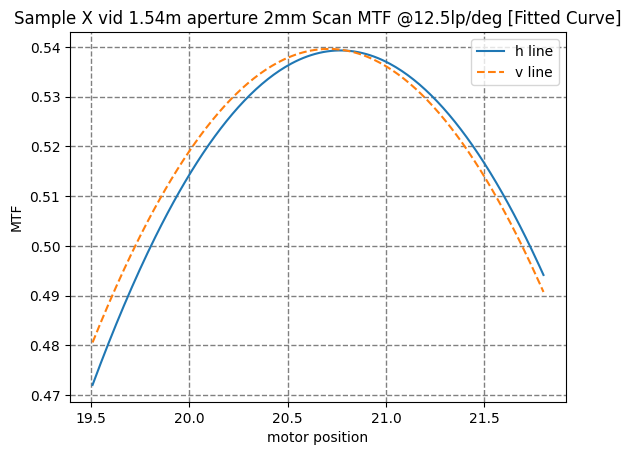

In [59]:
plot_thrufocus(ad, afh, afv, title=f"Sample X vid 1.54m aperture 2mm Scan MTF @{lpdg}lp/deg [Fitted Curve]")

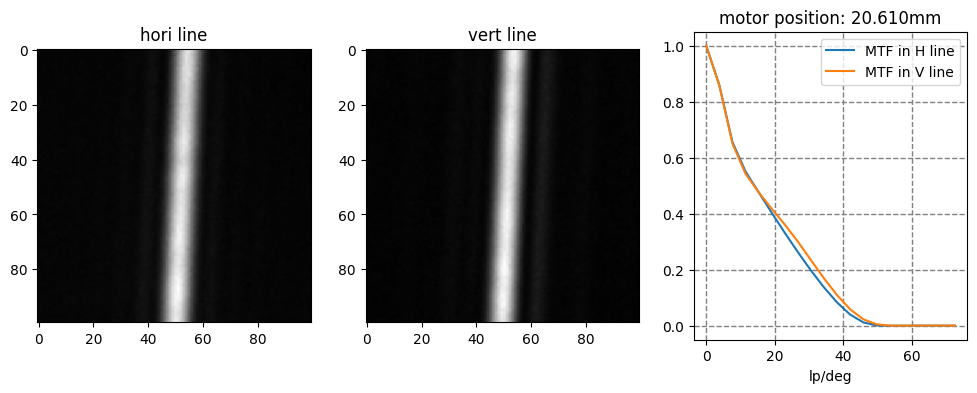

In [25]:
# P2 vid 1.54m #3
p2_2mm_140ma_2000us = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0814/p2_2mm_140ma_2000us/{idx/1000:.3f}.png",
    "roi_h_pos": (1314, 1080),
    "roi_v_pos": (1161, 1203),
} for idx in range(19510, 21900, 10)]

display_roi(p2_2mm_140ma_2000us, 110, 100, 100)

In [26]:
t_focus_d_p22mm, t_focus_h_p22mm, t_focus_v_p22mm = do_thru_focus(p2_2mm_140ma_2000us)

In [54]:
ad, ah, av = adjust_thrufocus(t_focus_d_p22mm, t_focus_h_p22mm, t_focus_v_p22mm, kh=1.00, kv = 1.00, shift=-9)
x = (np.arange(ah.shape[0]))
zh = np.polyfit(x, ah, 2)
ph = np.poly1d(zh)
afh = ph(x)
zv = np.polyfit(x, av, 2)
pv = np.poly1d(zv)
afv = pv(x)
print(afh.argmax(), afh.max())
print(afv.argmax(), afv.max())

122 0.5322054253711104
111 0.5273857658733734


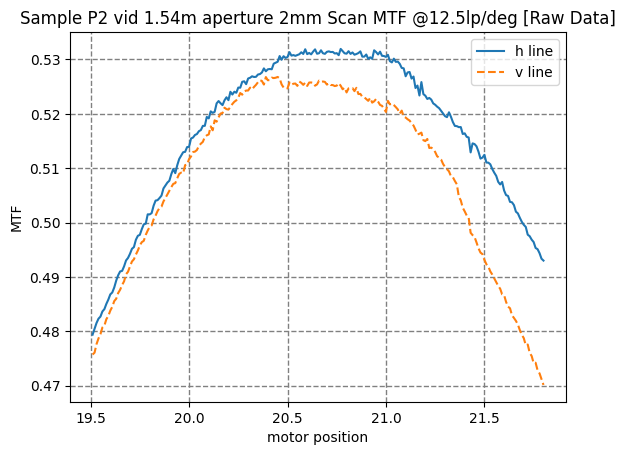

In [55]:
plot_thrufocus(ad, ah, av, title=f"Sample P2 vid 1.54m aperture 2mm Scan MTF @{lpdg}lp/deg [Raw Data]")

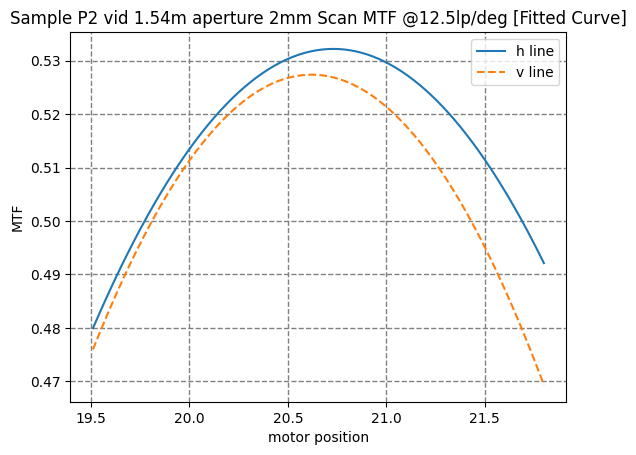

In [56]:
plot_thrufocus(ad, afh, afv, title=f"Sample P2 vid 1.54m aperture 2mm Scan MTF @{lpdg}lp/deg [Fitted Curve]")

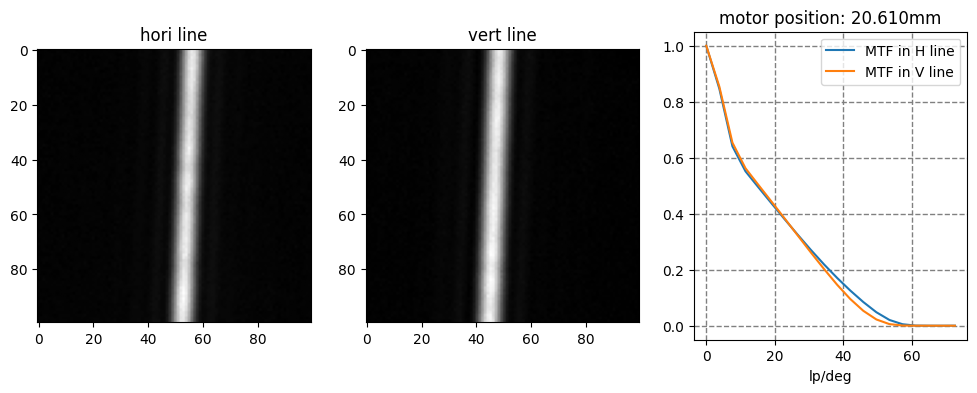

In [34]:
# PP1 vid 1.54m #3
pp1_2mm_140ma_2000us = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0814/pp1_2mm_140ma_2000us/{idx/1000:.3f}.png",
    "roi_h_pos": (1362, 1209),
    "roi_v_pos": (1212, 1341),
} for idx in range(19510, 21900, 10)]

display_roi(pp1_2mm_140ma_2000us, 110, 100, 100)

In [35]:
t_focus_d_pp12mm, t_focus_h_pp12mm, t_focus_v_pp12mm = do_thru_focus(pp1_2mm_140ma_2000us)

In [51]:
ad, ah, av = adjust_thrufocus(t_focus_d_pp12mm, t_focus_h_pp12mm, t_focus_v_pp12mm, kh=1.0, kv = 0.985, shift=-9)
x = (np.arange(ah.shape[0]))
zh = np.polyfit(x, ah, 2)
ph = np.poly1d(zh)
afh = ph(x)
zv = np.polyfit(x, av, 2)
pv = np.poly1d(zv)
afv = pv(x)
print(afh.argmax(), afh.max())
print(afv.argmax(), av.max())

118 0.5355275716440234
111 0.5391182565746483


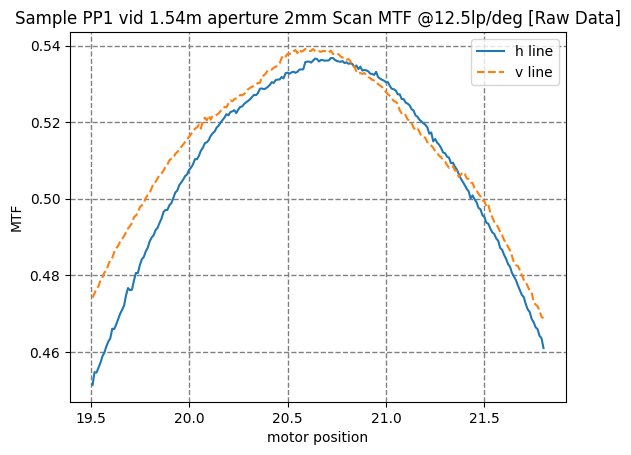

In [52]:
plot_thrufocus(ad, ah, av, title=f"Sample PP1 vid 1.54m aperture 2mm Scan MTF @{lpdg}lp/deg [Raw Data]")

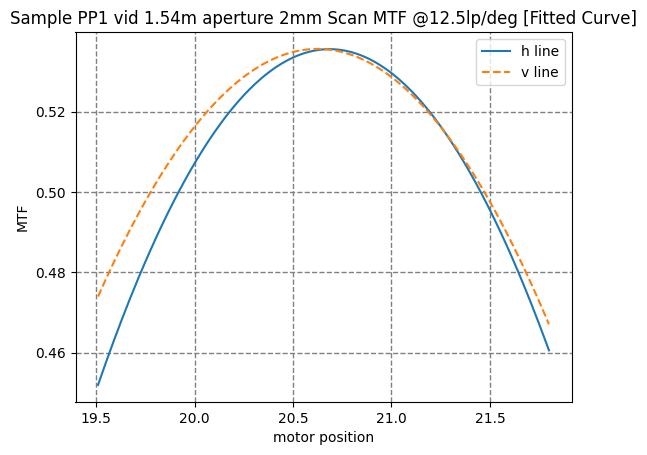

In [53]:
plot_thrufocus(ad, afh, afv, title=f"Sample PP1 vid 1.54m aperture 2mm Scan MTF @{lpdg}lp/deg [Fitted Curve]")

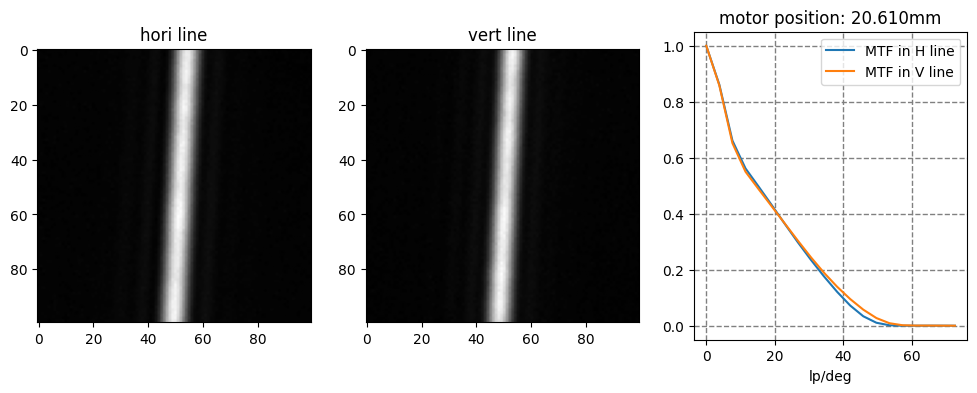

In [39]:
# Mirror vid 1.54m #3
mirror_2mm_140ma_2000us = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0814/mirror_2mm_140ma_2000us/{idx/1000:.3f}.png",
    "roi_h_pos": (1370, 928),
    "roi_v_pos": (1242, 1049),
} for idx in range(19510, 21900, 10)]

display_roi(mirror_2mm_140ma_2000us, 110, 100, 100)

In [40]:
t_focus_d_mirror2mm, t_focus_h_mirror2mm, t_focus_v_mirror2mm = do_thru_focus(mirror_2mm_140ma_2000us)

In [48]:
ad, ah, av = adjust_thrufocus(t_focus_d_mirror2mm, t_focus_h_mirror2mm, t_focus_v_mirror2mm, kh=1.001, kv = 1.012, shift=-9)
x = (np.arange(ah.shape[0]))
zh = np.polyfit(x, ah, 2)
ph = np.poly1d(zh)
afh = ph(x)
zv = np.polyfit(x, av, 2)
pv = np.poly1d(zv)
afv = pv(x)
print(afh.argmax(), ah.max())
print(afv.argmax(), av.max())

113 0.5453429938089938
113 0.5404186406396121


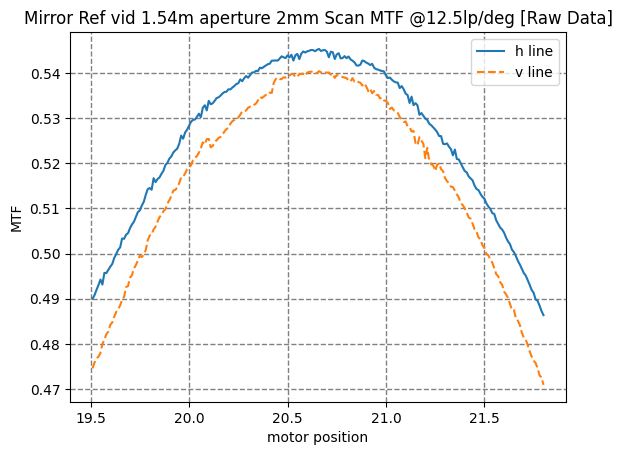

In [49]:
plot_thrufocus(ad, ah, av, title=f"Mirror Ref vid 1.54m aperture 2mm Scan MTF @{lpdg}lp/deg [Raw Data]")

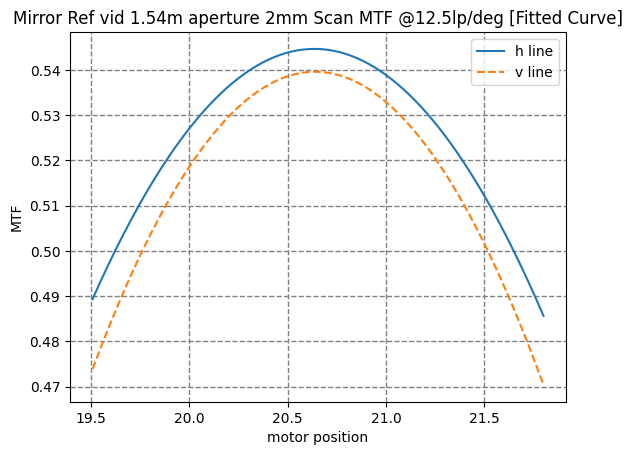

In [50]:
plot_thrufocus(ad, afh, afv, title=f"Mirror Ref vid 1.54m aperture 2mm Scan MTF @{lpdg}lp/deg [Fitted Curve]")